# Corrections to Last Week's Notebook
This notebook'll do things a little differently. I made quite a few mistakes in the last one; I'll address them all.

To begin, I was normalising my output arrays alone, and not my inputs, which may be one of the reasons why the model's accuracy suffered.

Further, I was normalising my output arrays with respect to the inclination parameter; as in, I normalised each sub-run of a SKIRT output file individually. What I should have done was generate the entire dataset, and *then* normalise it. Dimensionally, for each output type ($n, f$, or $r$), I'd normalise 1,000 arrays at a time, instead of 1.

Secondly, I'm going to use separate models to predict each output array, as opposed to using one model to predict all three simultaneously. The reason for this is that in the compact model, since the backwarded cost is the sum of the costs of all three outputs, the cost of one output affects the cost of another, independent output, which is sub-optimal. We need costs to be independent of each other, since their outputs are independent.

I'm going to use logarithmic scales to display my output arrays. I can't remember the reasoning behind this, but I'll do it anyway.

Since I'm using separate models for all three outputs, the question of whether or not normalisation is necessary remains. I won't implement it in the library that stores the model.

From here onwards, I'm no longer going to define the model every time I make a new notebook; I'll just have a separate python script that stores the model class for me: makes debugging a *lot* easier.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from plotter import Plotter
from radiative_transfer_bnn import RadiativeTransferBNN

In [7]:
model = RadiativeTransferBNN(1000, 0.3, 0.01, "flux")
# model.preprocess_data()
model.train_model(1000, 200)


c:\Users\resul\OneDrive\Physics\Final Year\PH30036\project_script\src\semester2\week7\radiative_transfer_bnn.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat(


['log_mstar' 'log_mdust_over_mstar' 'Rstar' 'Cstar' 'nstar' 'ndust' 'RdRs'
 'CdCs' 'f_cov' 'age' 't_peak' 'k_peak' 'fwhm' 'k_fwhm' 'metal' 'theta'
 'run_id' 'angle_id']
18
[<class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>]
Training the model...
- epoch 1/1000 - cost: 11.643, kl:                 0.050
- epoch 2/1000 - cost: 7.047, kl:                 0.085
- epoch 3/1000 - cost: 7.4

In [8]:
mean_pred_results, std_pred_results = model.test_model()
df = model.df
X_train = model.X_train
y_train = model.y_train

Testing the model...
inputs shape: torch.Size([210, 16])
self.input_mean shape: (16,)
- cost: 1.031
- this took 10.01 seconds


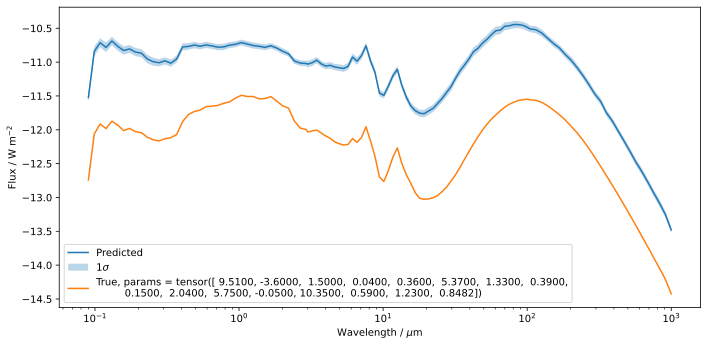

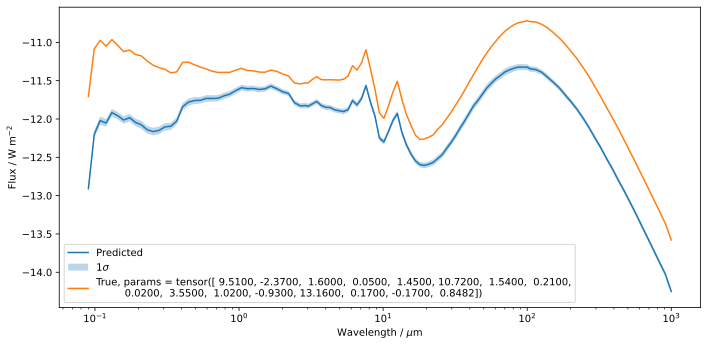

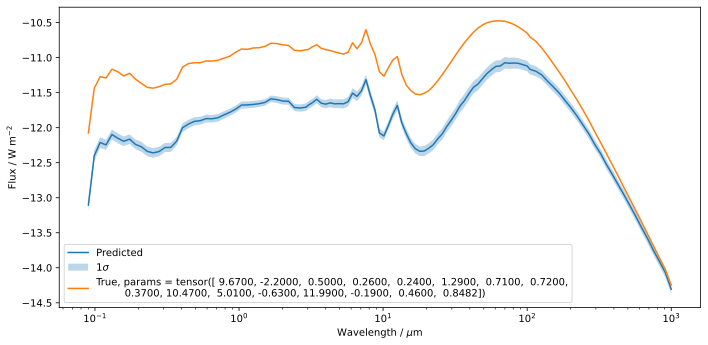

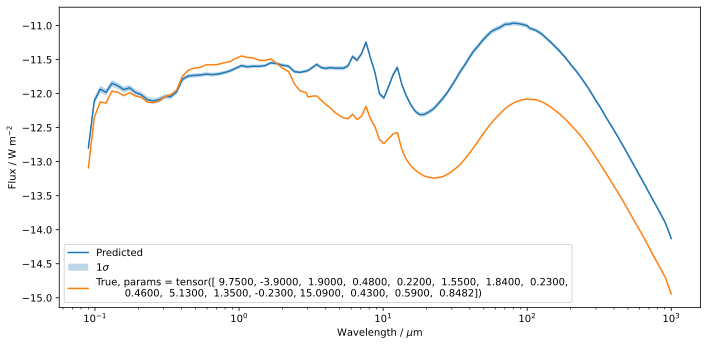

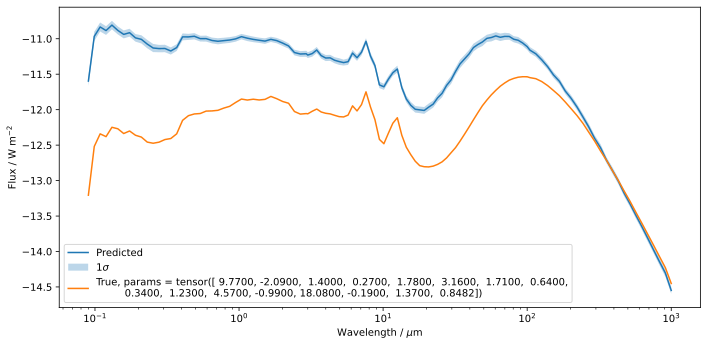

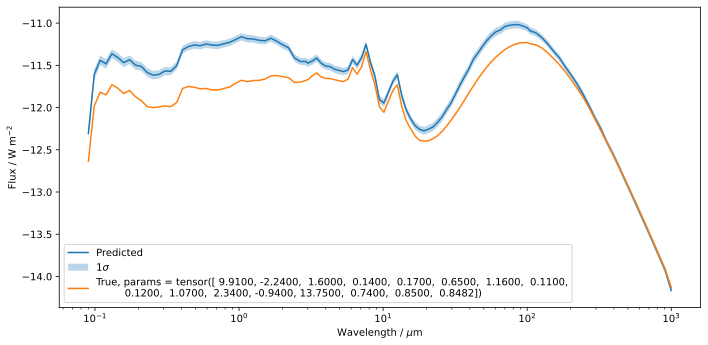

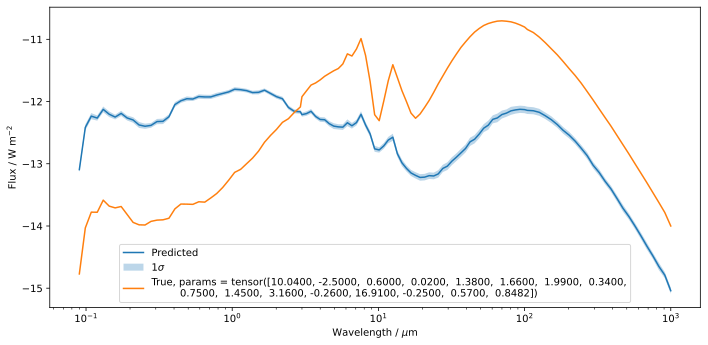

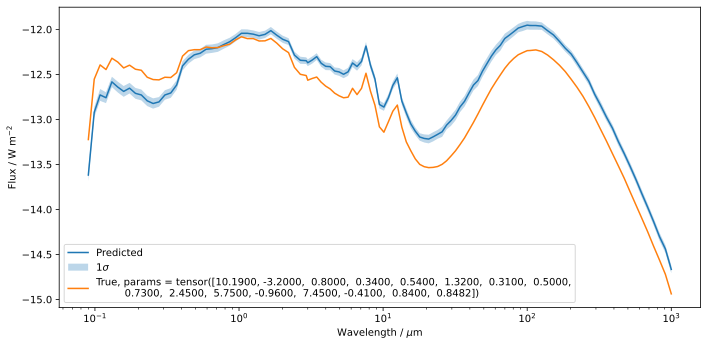

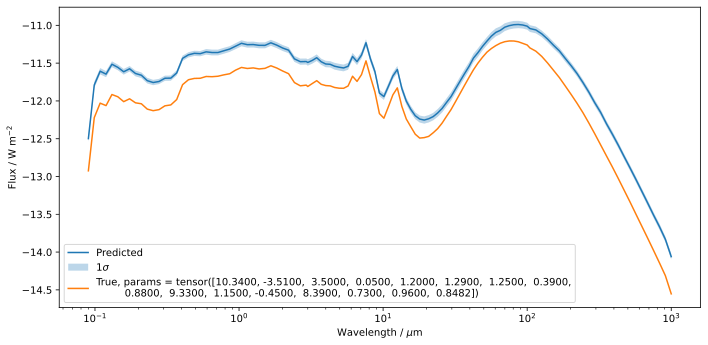

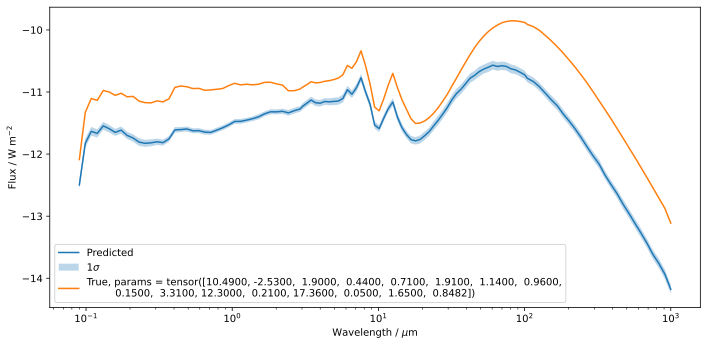

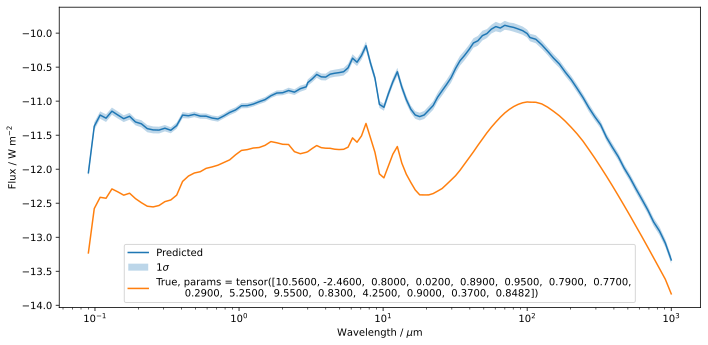

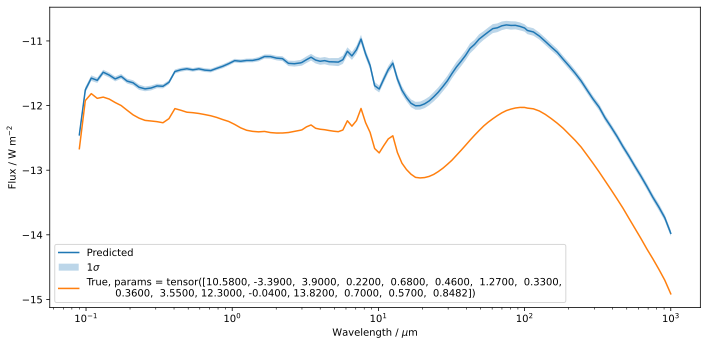

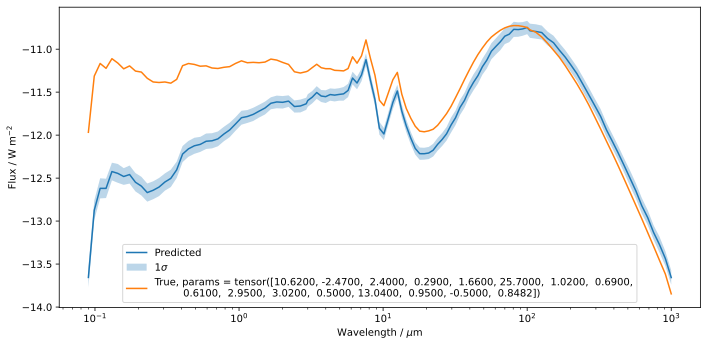

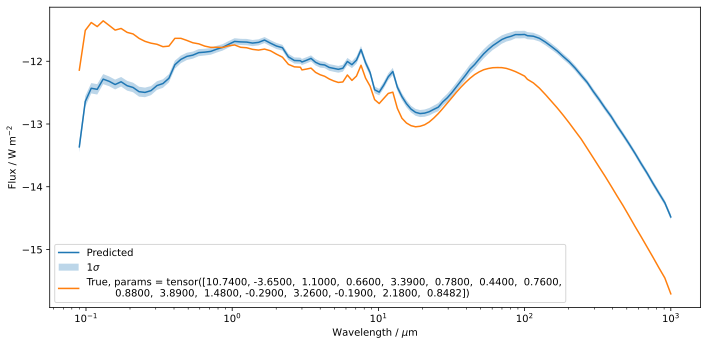

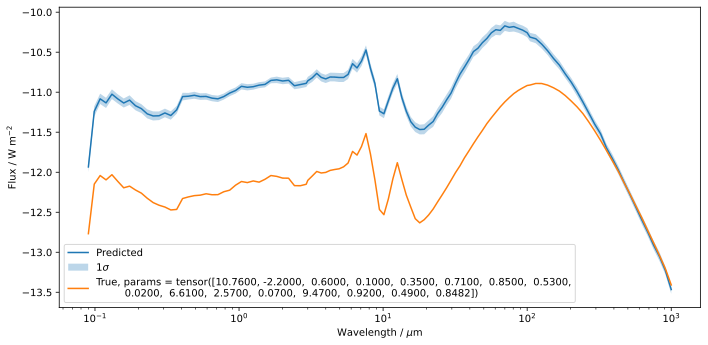

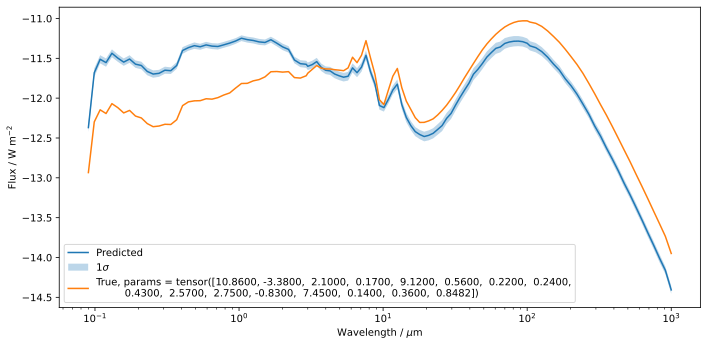

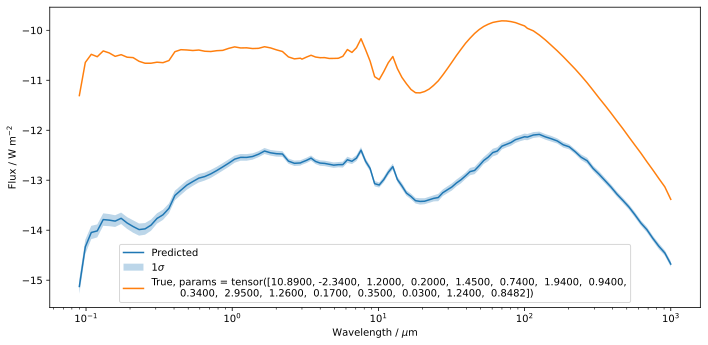

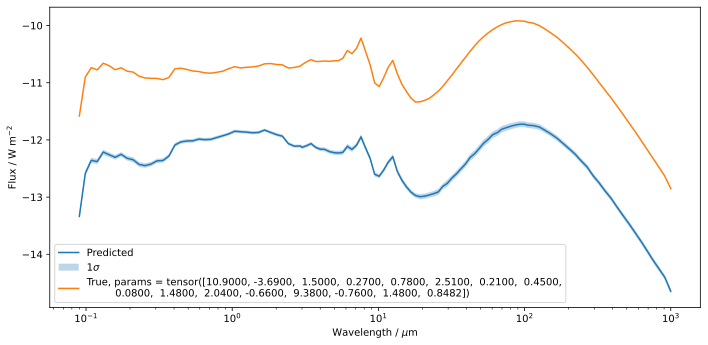

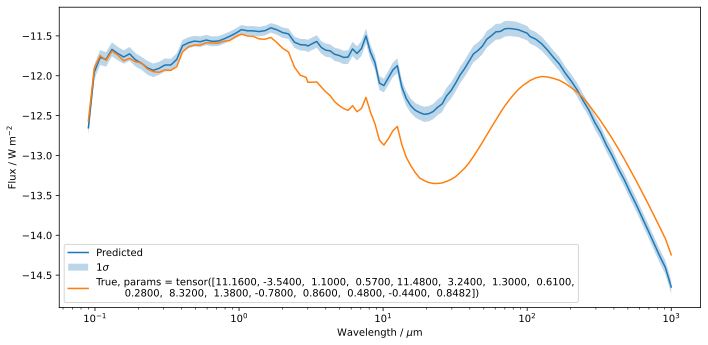

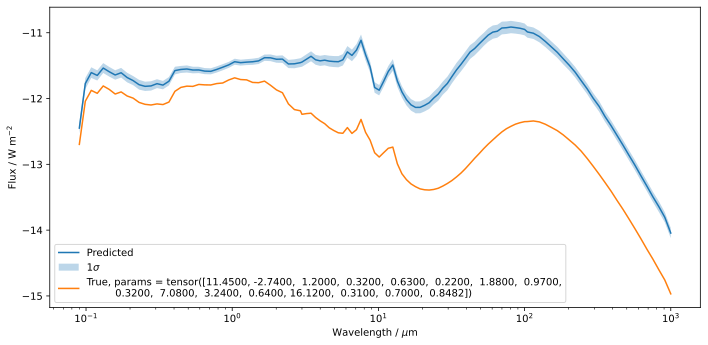

In [9]:
for i in range(0, 200, 10):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.plot(model.wavelength, mean_pred_results[i, :], label="Predicted")
    ax.fill_between(model.wavelength, mean_pred_results[i, :] - std_pred_results[i, :], mean_pred_results[i, :] + std_pred_results[i, :], alpha=0.3, label="1$\\sigma$")
    ax.plot(model.wavelength, model.y_test[i, :], label=f"True, params = {model.X_test[i]}")

    ax.set_xscale("log")
    ax.set_xlabel("Wavelength / $\\mu$m")
    ax.set_ylabel("Flux / W m$^{-2}$")
    ax.legend()
    fig.tight_layout()
    plt.show()
    plt.close()


In [10]:
star_mass = torch.linspace(10.5, 10.5, 20)
dust_mass = torch.linspace(5.5, 9.5, 20)
theta = torch.linspace(90, 90, 20)
x_pred = model.create_predict_tensor(star_mass, dust_mass, theta)
print(x_pred.shape)
mean_pred_results, std_pred_results = model.predict(x_pred)


torch.Size([20, 3])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x3 and 16x1000)

In [ ]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

for i in range(1, 20, 1):
    ax.plot(model.wavelength, mean_pred_results[i, :], label=f"Predicted, params = {x_pred[i]}")
    ax.fill_between(model.wavelength, mean_pred_results[i, :] - std_pred_results[i, :], mean_pred_results[i, :] + std_pred_results[i, :], alpha=0.3, label="1$\\sigma$")
    # ax.plot(model.wavelength, model.y_test[i, :], label=f"True, params = {model.X_test[i]}")

ax.set_xscale("log")
ax.set_xlabel("Wavelength / $\\mu$m")
ax.set_ylabel("Flux / W m$^{-2}$")
# ax.legend()
fig.tight_layout()

